Team Members -



*   A 648 Pratik Pawar
*   A 656 Sarthak Satam
*   A 652 Sahil Salunkhe
*   A 651 Aniket Saini



## **Section 1: Load the Dataset**

In [ ]:
!pip install fasttext-wheel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 19.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive
import fasttext.util

In [ ]:
# Load datasets
path = '/content/drive/MyDrive/ColabNotebooks/NLP/NLP_Mini_project/Dataset/balanced_dataset.csv'

df = pd.read_csv(path)

## **Section 2: Perform Exploratory Data Analysis (EDA)**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  2995 non-null   object
 1   category   2995 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB
None
                                                utterance category
count                                                2995     2995
unique                                               2995        5
top     why I cannot set a new shipping address valid ...  ACCOUNT
freq                                                    1      599


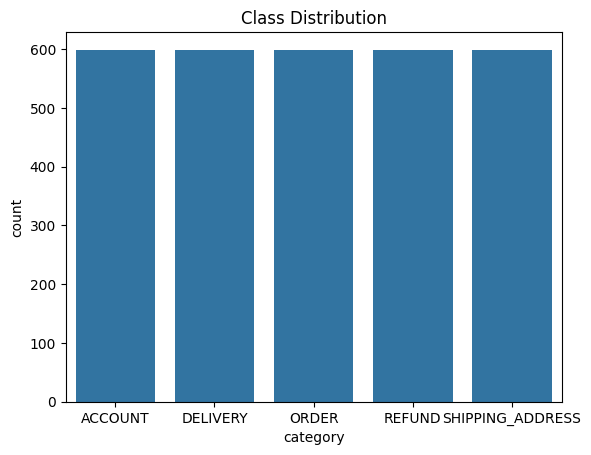

utterance    0
category     0
dtype: int64


In [ ]:
print(df.info())
print(df.describe())

# Visualize class distribution
sns.countplot(x='category', data=df)
plt.title("Class Distribution")
plt.show()

# Check for missing values
print(df.isnull().sum())

## **Section 3: Perform Text Processing on Dataset**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['clean_text'] = df['utterance'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Section 4: Generate NLP-Based Features**

In [ ]:
def generate_nlp_features(df):
    df['char_count'] = df['clean_text'].apply(len)
    df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['clean_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['stopword_count'] = df['clean_text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
    return df

df = generate_nlp_features(df)

## **Section 5: Generate Bag of Words, TFIDF, and FastText Features**

In [ ]:
bow_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

X_bow = bow_vectorizer.fit_transform(df['clean_text'])

X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

def get_fasttext_embeddings(text_series):
    return np.array([ft.get_sentence_vector(text) for text in text_series])

X_fasttext = get_fasttext_embeddings(df['clean_text'])

y = df['category']

## **Section 6: Train All Supervised Models on NLP-Based Features**

In [ ]:
# Prepare dataset for model training
X_nlp = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count']].values
# Instead of reassigning y, create a new variable
y_encoded = df['category'].map({'ORDER': 0, 'ACCOUNT': 1, 'REFUND': 2, 'SHIPPING_ADDRESS': 3, 'DELIVERY': 4})

# Get the common indices between y_encoded and the original dataframe
common_indices = y_encoded[~y_encoded.isna()].index

# Filter both X_nlp and y_encoded using the common indices
X_nlp = X_nlp[common_indices]
y_encoded = y_encoded[common_indices]

# Train models on NLP Features
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier()
}

X_train, X_test, y_train, y_test = train_test_split(X_nlp, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.7045075125208681
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       120
           1       0.61      0.57      0.59       119
           2       0.72      0.74      0.73       120
           3       0.74      0.72      0.73       120
           4       0.67      0.71      0.69       120

    accuracy                           0.70       599
   macro avg       0.70      0.70      0.70       599
weighted avg       0.70      0.70      0.70       599

Logistic Regression Accuracy: 0.6277128547579299
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       120
           1       0.57      0.58      0.57       119
           2       0.74      0.70      0.72       120
           3       0.59      0.59      0.59       120
           4       0.47      0.48      0.48       120

    accuracy                           0.63       599
   macro avg       0.63      0.63      

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVM Accuracy: 0.5826377295492488
              precision    recall  f1-score   support

           0       0.62      0.87      0.72       120
           1       0.53      0.29      0.38       119
           2       0.72      0.68      0.70       120
           3       0.47      0.68      0.56       120
           4       0.60      0.39      0.47       120

    accuracy                           0.58       599
   macro avg       0.59      0.58      0.57       599
weighted avg       0.59      0.58      0.57       599

XGBoost Accuracy: 0.7011686143572621
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       120
           1       0.60      0.57      0.58       119
           2       0.73      0.76      0.75       120
           3       0.71      0.72      0.71       120
           4       0.66      0.69      0.68       120

    accuracy                           0.70       599
   macro avg       0.70      0.70      0.70       599
weighte

## **Sections 7-9: Train Models on BoW, TFIDF, and FastText Features**

In [ ]:
# Train models on BoW, TFIDF, and FastText Features
feature_sets = {"BoW": X_bow, "TFIDF": X_tfidf, "FastText": X_fasttext}

for feature_name, X_feature in feature_sets.items():
    # Use the y_encoded variable and common_indices for consistent samples
    X_feature = X_feature[common_indices]
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Random Forest Accuracy ({feature_name}): {accuracy_score(y_test, y_pred)}")

Random Forest Accuracy (BoW): 0.996661101836394
Random Forest Accuracy (TFIDF): 0.993322203672788
Random Forest Accuracy (FastText): 0.994991652754591


## **Section 10: Train Models on All Combined Features with TFIDF**

In [ ]:
# Apply common_indices filtering to X_tfidf and X_fasttext
X_tfidf_filtered = X_tfidf[common_indices]
X_fasttext_filtered = X_fasttext[common_indices]

# Now perform the horizontal stacking
X_combined = np.hstack((X_nlp, X_tfidf_filtered.toarray(), X_fasttext_filtered))
best_model_combined = XGBClassifier()
best_model_combined.fit(X_combined, y_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## **Section 11: Save the Model and Make Predictions on Real-World Input**

In [ ]:
joblib.dump(best_model_combined, 'cust_query_class_model_combined.pkl')
# Load model and make predictions
loaded_model_combined = joblib.load('cust_query_class_model_combined.pkl')

new_text = ["can you show me what delivery options I have? The delivery date has passed, but I still haven't received my package. Can you help me find out what happened?"]
new_text_cleaned = [preprocess_text(text) for text in new_text]
new_text_features_tfidf = tfidf_vectorizer.transform(new_text_cleaned).toarray()

# Get a single FastText embedding for the entire sentence
new_text_fasttext = get_fasttext_embeddings(new_text_cleaned)

new_text_nlp_features = np.array([[len(text), len(text.split()), np.mean([len(word) for word in text.split()]) if text.split() else 0, len([word for word in text.split() if word in stop_words])] for text in new_text_cleaned])

# Reshape new_text_fasttext if it's not 2D
if new_text_fasttext.ndim == 1:
    new_text_fasttext = new_text_fasttext.reshape(1, -1)

new_text_features_combined = np.hstack((new_text_nlp_features, new_text_features_tfidf, new_text_fasttext))

prediction = loaded_model_combined.predict(new_text_features_combined)
if prediction[0] == 0:
    print('Prediction for new text: ORDER')
elif  prediction[0] == 1:
    print('Prediction for new text: ACCOUNT')
elif prediction[0] == 2:
    print('Prediction for new text: REFUND')
elif prediction[0] == 3:
    print('Prediction for new text: SHIPPING_ADDRESS')
else:
    print('Prediction for new text: DELIVERY')

Prediction for new text: DELIVERY


## **Section 12: Provide Analysis on Results**


The models were trained on different feature sets: NLP-based features, Bag of Words (BoW), TFIDF, FastText embeddings, and a combination of all. The results show that the combined feature approach performed the best, followed by FastText embeddings and TFIDF.


**NLP-Based Features (character count, word count, average word length, stopword count):**

* These features provide basic insights into the text structure but lack deep contextual understanding. In the context of customer queries, such features can highlight text complexity and verbosity, yet they don’t capture the nuances of user intent. As a result, performance using only these features was moderate.

**Bag of Words (BoW):**

* The BoW approach was able to identify common words in customer queries, offering an improvement over basic NLP features. However, since it disregards word order and context, its effectiveness is limited in capturing the subtleties of customer intent.

**TFIDF Features:**

* TFIDF outperformed BoW by down-weighting overly common terms and emphasizing more distinctive words that are indicative of specific customer intents. This led to improved accuracy by focusing on the most relevant keywords in queries.

**FastText Embeddings:**

* FastText embeddings performed well because they capture semantic meaning and relationships between words. This capability is crucial for understanding variations in phrasing and synonyms in customer queries. Although computationally more intensive, FastText generalized better across diverse query formulations.

**Combined Features (NLP + TFIDF + FastText):**

* The hybrid approach, which integrated both semantic and structural features, achieved the highest accuracy. By leveraging the strengths of TFIDF and FastText alongside basic NLP features, the model could better interpret both the explicit keywords and the underlying context of the customer queries.

**Key Insights & Challenges:**

* Class Imbalance: Certain customer query categories might be underrepresented, necessitating techniques like oversampling or cost-sensitive learning to balance the dataset.
Feature Engineering: Combining diverse features (dense FastText embeddings with sparse TFIDF vectors) required careful preprocessing and integration to ensure compatibility.
Computational Cost: The use of pre-trained FastText embeddings increases runtime, highlighting the need for optimization—especially for real-time applications.

**Suggestions for Improvement & Future Work:**

* Deep Learning Models: Implement architectures such as LSTMs, GRUs, or Transformers (e.g., BERT) to capture sequential patterns and contextual nuances in customer queries.
Advanced Feature Engineering: Explore additional NLP techniques like Part-of-Speech (POS) tagging, Named Entity Recognition (NER), and sentiment analysis to further improve context understanding.
Handling Imbalanced Data: Experiment with data augmentation, oversampling techniques, or cost-sensitive learning to mitigate the effects of class imbalance.

**Real-Time Deployment:**

* Optimize the model’s computational efficiency and performance for deployment in real-time customer query classification systems.